In [3]:
"""
This is an example of using the k-nearest-neighbors (KNN) algorithm for face recognition.
When should I use this example?
This example is useful when you wish to recognize a large set of known people,
and make a prediction for an unknown person in a feasible computation time.
Algorithm Description:
The knn classifier is first trained on a set of labeled (known) faces and can then predict the person
in an unknown image by finding the k most similar faces (images with closet face-features under euclidean distance)
in its training set, and performing a majority vote (possibly weighted) on their label.
For example, if k=3, and the three closest face images to the given image in the training set are one image of Biden
and two images of Obama, The result would be 'Obama'.
* This implementation uses a weighted vote, such that the votes of closer-neighbors are weighted more heavily.
Usage:
1. Prepare a set of images of the known people you want to recognize. Organize the images in a single directory
   with a sub-directory for each known person.
2. Then, call the 'train' function with the appropriate parameters. Make sure to pass in the 'model_save_path' if you
   want to save the model to disk so you can re-use the model without having to re-train it.
3. Call 'predict' and pass in your trained model to recognize the people in an unknown image.
NOTE: This example requires scikit-learn to be installed! You can install it with pip:
$ pip3 install scikit-learn
"""

import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}


def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.
    :param train_dir: directory that contains a sub-directory for each known person, with its name.
     (View in source code to see train_dir example tree structure)
     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier
    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]


def show_prediction_labels_on_image(img_path, predictions):
    """
    Shows the face recognition results visually.
    :param img_path: path to image to be recognized
    :param predictions: results of the predict function
    :return:
    """
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left) in predictions:
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        name = name.encode("UTF-8")

        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Display the resulting image
    pil_image.show()


if __name__ == "__main__":
    # STEP 1: Train the KNN classifier and save it to disk
    # Once the model is trained and saved, you can skip this step next time.
    print("Training KNN classifier...")
    classifier = train("knn_examples/train", model_save_path="trained_knn_model.clf", n_neighbors=2)
    print("Training complete!")

    # STEP 2: Using the trained classifier, make predictions for unknown images
    for image_file in os.listdir("knn_examples/test"):
        full_file_path = os.path.join("knn_examples/test", image_file)

        print("Looking for faces in {}".format(image_file))

        # Find all people in the image using a trained classifier model
        # Note: You can pass in either a classifier file name or a classifier model instance
        predictions = predict(full_file_path, model_path="trained_knn_model.clf")

        # Print results on the console
        for name, (top, right, bottom, left) in predictions:
            print("- Found {} at ({}, {})".format(name, left, top))

        # Display results overlaid on an image
        show_prediction_labels_on_image(os.path.join("knn_examples/test", image_file), predictions)

ModuleNotFoundError: No module named 'face_recognition'

In [4]:

obj = tk.Tk() # Creates a tkinter object
label = tk.Label(obj, text="This is a text button")


NameError: name 'tk' is not defined

In [5]:
import Tkinter
top = Tkinter.Tk()
# Code to add widgets will go here...
top.mainloop()


ModuleNotFoundError: No module named 'Tkinter'

In [ ]:
import numpy as np

In [6]:
import pandas as pd
crics= pd.read_csv('C:\\Users\\DELL\\Desktop\\crick.csv')


In [7]:
crics

,Overall figures,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,Span,Mat,Inns,NO,Runs,HS,Ave,100.0,50.0,0.0,NaN
1,NaN,1989-2013,200,329,33,15921,248*,53.78,51.0,68.0,14.0,NaN
2,NaN,1995-2012,168,287,29,13378,257,51.85,41.0,62.0,17.0,NaN
3,NaN,1995-2013,166,280,40,13289,224,55.37,45.0,58.0,16.0,NaN
4,NaN,1996-2012,164,286,32,13288,270,52.31,36.0,63.0,8.0,NaN
5,NaN,2006-2018,161,291,16,12472,294,45.35,33.0,57.0,9.0,NaN
6,NaN,2000-2015,134,233,17,12400,319,57.4,38.0,52.0,11.0,NaN
7,NaN,1990-2006,131,232,6,11953,400*,52.88,34.0,48.0,17.0,NaN
8,NaN,1994-2015,164,280,49,11867,203*,51.37,30.0,66.0,15.0,NaN
9,NaN,1997-2014,149,252,15,11814,374,49.84,34.0,50.0,15.0,NaN


In [8]:
import sklearn as sk


In [9]:
x=dir(sk)
print(x)

['__SKLEARN_SETUP__', '__all__', '__builtins__', '__cached__', '__check_build', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_config', '_distributor_init', 'base', 'clone', 'config_context', 'decomposition', 'exceptions', 'externals', 'get_config', 'linear_model', 'logger', 'logging', 'metrics', 'model_selection', 'neighbors', 'os', 'preprocessing', 're', 'set_config', 'setup_module', 'show_versions', 'svm', 'sys', 'utils']


In [ ]:
#import the necessary module
from sklearn import preprocessing
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
encoded_value = le.fit_transform(["paris", "paris", "tokyo", "amsterdam", "Galle", "Mumbai" , "Galle", "New York", "Godakanda"])
print(encoded_value)

In [10]:
import pandas as pd
import os

In [11]:
sales = pd.read_csv("E:\data science\Pandas-Data-Science-Tasks\SalesAnalysis\Sales_Data\Sales_April_2019.csv")
files = [file for file in os.listdir('E:\data science\Pandas-Data-Science-Tasks\SalesAnalysis\Sales_Data')]

all_months_data = pd.DataFrame()

for file in files:
    sales = pd.read_csv("E:/data science/Pandas-Data-Science-Tasks/SalesAnalysis/Sales_Data/"+file)
    all_months_data = pd.concat([all_months_data, sales])
    
sales.head()   
    

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,248151,AA Batteries (4-pack),4,3.84,09/17/19 14:44,"380 North St, Los Angeles, CA 90001"
1,248152,USB-C Charging Cable,2,11.95,09/29/19 10:19,"511 8th St, Austin, TX 73301"
2,248153,USB-C Charging Cable,1,11.95,09/16/19 17:48,"151 Johnson St, Los Angeles, CA 90001"
3,248154,27in FHD Monitor,1,149.99,09/27/19 07:52,"355 Hickory St, Seattle, WA 98101"
4,248155,USB-C Charging Cable,1,11.95,09/01/19 19:03,"125 5th St, Atlanta, GA 30301"


In [12]:
nan_df=all_months_data[all_months_data.isna().any(axis=1)]
nan_df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
10012,NaN,NaN,NaN,NaN,NaN,NaN
10274,NaN,NaN,NaN,NaN,NaN,NaN
10878,NaN,NaN,NaN,NaN,NaN,NaN
11384,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
all_data=all_months_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [14]:
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [15]:
all_data=all_data[all_data['Order Date'].str[0:2]!='Or']
all_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
11681,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001"
11682,259354,iPhone,1,700,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016"
11683,259355,iPhone,1,700,09/23/19 07:39,"220 12th St, San Francisco, CA 94016"
11684,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016"


In [16]:
all_data['Month']=all_data['Order Date'].str[0:2]
all_data['Month']=all_data['Month'].astype('int32')
all_data.head(100)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4
...,...,...,...,...,...,...,...
96,176649,USB-C Charging Cable,1,11.95,04/09/19 08:49,"702 11th St, San Francisco, CA 94016",4
97,176650,Lightning Charging Cable,1,14.95,04/12/19 16:47,"153 River St, Boston, MA 02215",4
98,176651,iPhone,1,700,04/07/19 13:14,"997 South St, Boston, MA 02215",4
99,176652,LG Washing Machine,1,600.0,04/09/19 20:04,"502 14th St, New York City, NY 10001",4


In [18]:
all_data['Quantity Ordered']=pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each']=pd.to_numeric(all_data['Price Each'])

In [19]:
all_data['Sales']=all_data['Quantity Ordered']*all_data['Price Each']
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,23.90
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,99.99
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,600.00
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,11.99
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,11.99


In [21]:
def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: get_city(x)+ ' '+ get_state(x))

all_data= all_data.drop(columns ='Column')
all_data.head()                                                   

KeyError: "['Column'] not found in axis"

In [ ]:
#-----




In [22]:
all_data.groupby('Month').sum()

,Quantity Ordered,Price Each,Sales
Month,,,
1,10903,1.811768e+06,1.822257e+06
2,13449,2.188885e+06,2.202022e+06
3,17005,2.791208e+06,2.807100e+06
4,20558,3.367671e+06,3.390670e+06
5,18667,3.135125e+06,3.152607e+06
6,15253,2.562026e+06,2.577802e+06
7,16072,2.632540e+06,2.647776e+06
8,13448,2.230345e+06,2.244468e+06
9,13109,2.084992e+06,2.097560e+06


In [23]:
all_data.groupby('City').sum()

,Quantity Ordered,Price Each,Month,Sales
City,,,,
Atlanta GA,16602,2.779908e+06,104794,2.795499e+06
Austin TX,11153,1.809874e+06,69829,1.819582e+06
Boston MA,22528,3.637410e+06,141112,3.661642e+06
Dallas TX,16730,2.752628e+06,104620,2.767975e+06
Los Angeles CA,33289,5.421435e+06,208325,5.452571e+06
New York City NY,27932,4.635371e+06,175741,4.664317e+06
Portland ME,2750,4.471893e+05,17144,4.497583e+05
Portland OR,11303,1.860558e+06,70621,1.870732e+06
San Francisco CA,50239,8.211462e+06,315520,8.262204e+06


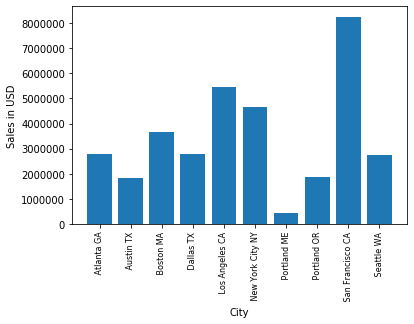

In [24]:
results=all_data.groupby('City').sum()

import matplotlib.pyplot as plt
city= [city for city, df in all_data.groupby('City')]

plt.bar(city,results['Sales'])
plt.xticks(city,rotation='vertical',size=8)
plt.ylabel('Sales in USD')
plt.xlabel('City')
plt.show()


In [26]:
results=all_data.groupby('Month').sum()

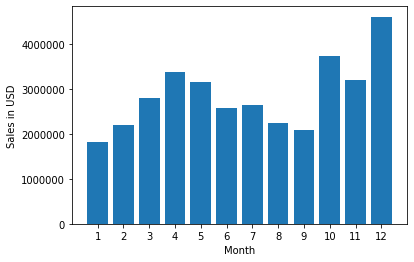

In [27]:
import matplotlib.pyplot as plt
months= range(1,13)
plt.bar(months,results['Sales'])
plt.xticks(months)
plt.ylabel('Sales in USD')
plt.xlabel('Month')
plt.show()

In [28]:
all_data['Order Date']=pd.to_datetime(all_data['Order Date'])
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA


In [29]:
all_data['Hour']=all_data['Order Date'].dt.hour
all_data['Minute']=all_data['Order Date'].dt.minute
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Minute
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX,8,46
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA,22,30
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA,14,38
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,14,38
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,9,27


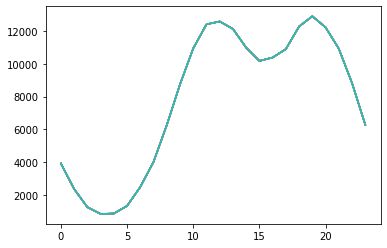

In [30]:
hours = [hour for hour , df in all_data.groupby('Hour')]
plt.plot(hours, all_data.groupby(['Hour']).count())